In [15]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mlp
from matplotlib import tri, cm
import time
from tqdm import tqdm

Definições Geométricas

In [51]:
Lx = 1
Nx = 100

Ly = 1
Ny = 100

dt = 1e-4
Nt = 10_000
T = np.arange(0, Nt*dt, dt)

Npoints = Nx*Ny

Definições do material

In [19]:
# Boundary conditions
# Tcc = lambda x, y, t: x*x + y*y + np.exp(t)
Tcc = lambda x, y, t: (x*x + y*y)*np.exp(-t) 
# Tcc = lambda x, y, t: 1

In [20]:
rho = 1
cv = 1
kappa = 1
alpha = kappa/(rho*cv)

# Q = lambda t: np.exp(t)*rho*cv - 4*kappa
Q = lambda x, y, t: -( x*x + y*y + 4*alpha )*np.exp(-t)*rho*cv

In [21]:
### Time discretization
# beta = 0.0 : Explicit
# beta = 0.5 : Crank-Nicholson
# beta = 1.0 : Implicit
beta = 0.5

In [22]:
X = np.linspace(0, Lx, Nx, dtype = float)
Y = np.linspace(0, Ly, Ny, dtype = float)

Xv, Yv = np.meshgrid(X, Y)

X = np.reshape(Xv, Npoints)
Y = np.reshape(Yv, Npoints)

In [23]:
# nos de condicao de contorno
cc1 = np.arange(           start = 0,           stop = Nx,  step = 1) # bottom 
cc2 = np.arange(          start = Nx, stop = Npoints - Nx, step = Nx) # left
cc3 = np.arange(start = Npoints - Nx,      stop = Npoints,  step = 1) # top
cc4 = np.arange(    start = 2*Nx - 1, stop = Npoints - Nx, step = Nx) # right

cc = np.hstack([cc1,cc2,cc3,cc4])

In [24]:
## IEN 
# 0  ,  nx      ,  nx + 1 : type 1
# 0  ,  nx + 1  ,  1      : type 2

IEN = [
    [0, Nx + 1, Nx    ],
    [0,      1, Nx + 1]
]

for i in range(Ny - 1):
    
    for j in range(Nx - 2):
        IEN.append([IEN[-2][k] + 1 for k in range(3)])
        IEN.append([IEN[-2][k] + 1 for k in range(3)])

    if i < Ny - 2:
        IEN.append([IEN[0][k] + Nx*(i + 1) for k in range(3)])
        IEN.append([IEN[1][k] + Nx*(i + 1) for k in range(3)])


In [25]:
#form functions for 2D
def IENfunc(K, M, IEN):
    for IENelem in IEN:
        tri_matrix = [[1, X[IENelem[i]], Y[IENelem[i]]] for i in range(3)]

        tri_area = 0.5*np.linalg.det(tri_matrix)

        [a_list, b_list, c_list] = np.linalg.inv(tri_matrix)

        melem = (tri_area/12)*np.array(([2, 1, 1],
                                        [1, 2, 1],
                                        [1, 1, 2]))

        kxelem = (alpha*tri_area)*np.array([[b_list[i]*b_list[j] for i in range(3)] for j in range(3)])
        kyelem = (alpha*tri_area)*np.array([[c_list[i]*c_list[j] for i in range(3)] for j in range(3)])

        kelem = kxelem + kyelem

        for ilocal in range(3):
            iglobal = IENelem[ilocal]

            for jlocal in range(3):
                jglobal = IENelem[jlocal]

                K[iglobal,jglobal] += kelem[ilocal,jlocal]
                M[iglobal,jglobal] += melem[ilocal,jlocal]

In [26]:
K  = np.zeros((Npoints, Npoints), dtype = float) 
M  = np.zeros((Npoints, Npoints), dtype = float)

IENfunc(K, M, IEN)

In [27]:
# Inicialização do primeiro passo de tempo
T_vec = np.zeros((Nt, Npoints))

# for i in cc: T_vec[0][i] = 1
T_vec[0] = np.zeros(Npoints)

T_vec[0] = [Tcc(X[i], Y[i], 0) for i in range(Npoints)]
# for i in cc: T_vec[0][i] = Tcc(X[i], Y[i], 0)

In [28]:
A = M/dt + beta*K

for i in cc:
    A[i, :] = 0.0
    A[i, i] = 1.0

Ainv = np.linalg.inv(A)

In [29]:
A2 = M/dt - (1 - beta)*K

In [30]:
def Q_vec(t, beta):
    Q_vec_prev = np.array([Q(X[i], Y[i], t - dt) for i in range(Npoints)])  
    Q_vec_curr = np.array([Q(X[i], Y[i], t) for i in range(Npoints)])  
    
    Q_vec = beta*Q_vec_prev + (1 - beta)*Q_vec_curr 

    return Q_vec   

In [31]:
for i in tqdm(range(1, Nt)):  
    q_vec = Q_vec(T[i], beta)
    
    b = A2@T_vec[i - 1] + M@q_vec

    for j in cc:
        b[j] = Tcc(X[j], Y[j], T[i])

    T_vec[i] = Ainv@b

100%|██████████| 9999/9999 [16:19<00:00, 10.21it/s]


In [32]:
expected_T = np.array([[Tcc(X[i], Y[i], T[j]) for i in range(Npoints)] for j in range(Nt)])

In [33]:
error = abs(T_vec - expected_T)

In [34]:
error_MSE = [np.sqrt(sum(elem**2)/Npoints) for elem in error]

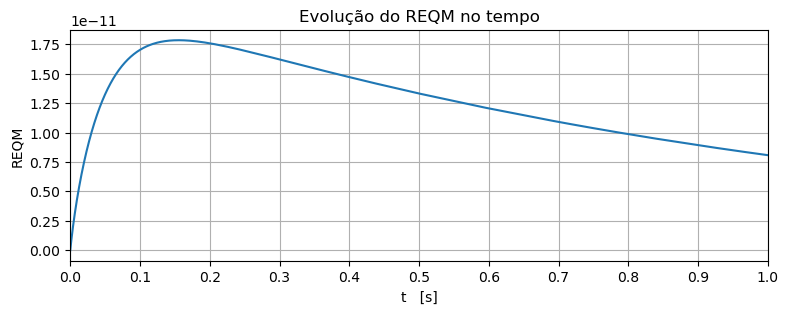

In [67]:
fig, axs = plt.subplots(1, 1, figsize = (9, 3))
plt.plot(T, error_MSE)
plt.grid()
plt.xlabel('t   [s]')
plt.ylabel('REQM')
plt.title('Evolução do REQM no tempo')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.xlim(0, 1)
plt.show()

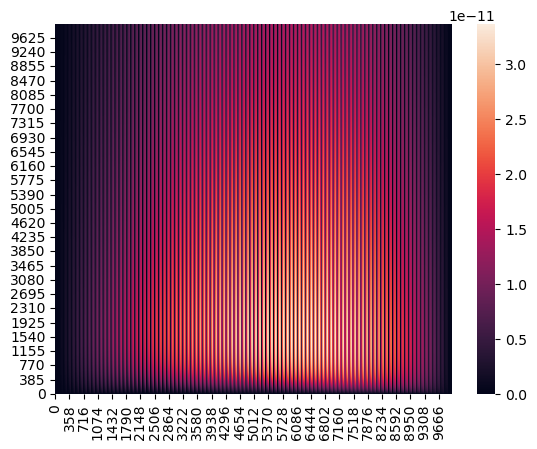

In [36]:
ax = sns.heatmap(error)
ax.invert_yaxis()
plt.show()

In [104]:
triang = tri.Triangulation(X,Y)

/var/folders/xc/tffvs1z54w7bwv3cb731l0dc0000gn/T/ipykernel_1243/2138233320.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad = 4)


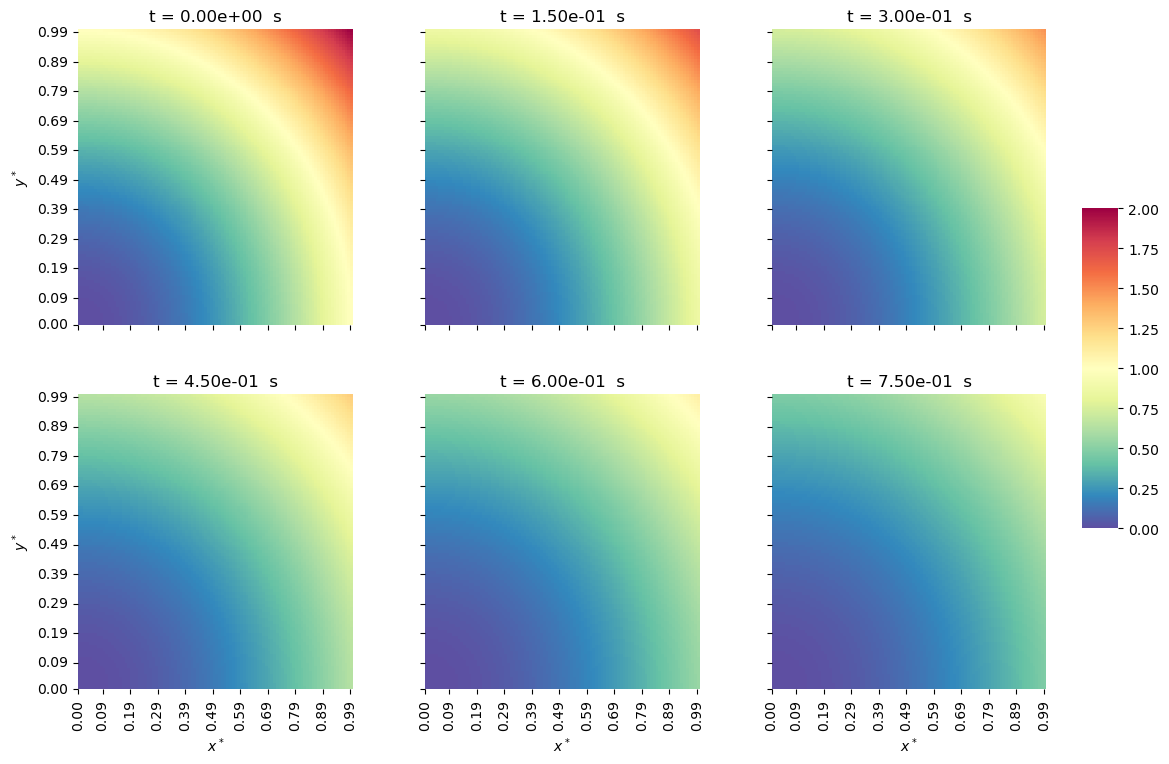

In [69]:
N = 6
start = 0
step = 1_500
setLimits = [0, 2]

nlines = N // 3
fig, axs = plt.subplots(nlines, 3, figsize = (12, 4*nlines), sharex = True, sharey = True)
fig.tight_layout(pad = 5)

num_ticks = 11
# number of points in x and y
nx = len(Xv)
ny = len(Yv)
# the index of the position of yticks
yticks = np.linspace(0, len(Yv) - 1, num_ticks, dtype=int)
xticks = np.linspace(0, len(Xv) - 1, num_ticks, dtype=int)

fmtx = lambda x, pos: '{:.2f}'.format(x*Lx/nx, pos)
fmty = lambda y, pos: '{:.2f}'.format(y*Ly/ny, pos)
    
cbar_ax = fig.add_axes([.91, .3, .03, .4])

fig.tight_layout(pad = 4)
plt.subplots_adjust(right = 0.88)

for i in range(N):
    idxLine = i//3
    idxCol = i % 3

    idx = start + step*i

    T = np.reshape(T_vec[idx], (Nx, Ny))
    
    if len(setLimits) == 0:
        minV = min(T_vec[idx])
        maxV = max(T_vec[idx])
    else:
        minV = setLimits[0]
        maxV = setLimits[1]


    sns.heatmap(
    T,
    ax = axs[idxLine, idxCol],
    cmap = "Spectral_r",
    vmin = minV,
    vmax = maxV,
    cbar_ax= cbar_ax
    )

    axs[idxLine, idxCol].invert_yaxis()
    axs[idxLine, idxCol].set_xticks(xticks)
    axs[idxLine, idxCol].set_yticks(yticks)

    if idxLine == nlines - 1: axs[idxLine, idxCol].set(xlabel = r'$x^*$')
    if idxCol  == 0: axs[idxLine, idxCol].set(ylabel = r'$y^*$')
    axs[idxLine, idxCol].set_title('t = %.2e  s' % ((idx)*dt))
    axs[idxLine, idxCol].xaxis.set_major_formatter(mlp.ticker.FuncFormatter(fmtx))
    axs[idxLine, idxCol].yaxis.set_major_formatter(mlp.ticker.FuncFormatter(fmty))

plt.show()

/var/folders/xc/tffvs1z54w7bwv3cb731l0dc0000gn/T/ipykernel_1243/935418060.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad = 4)


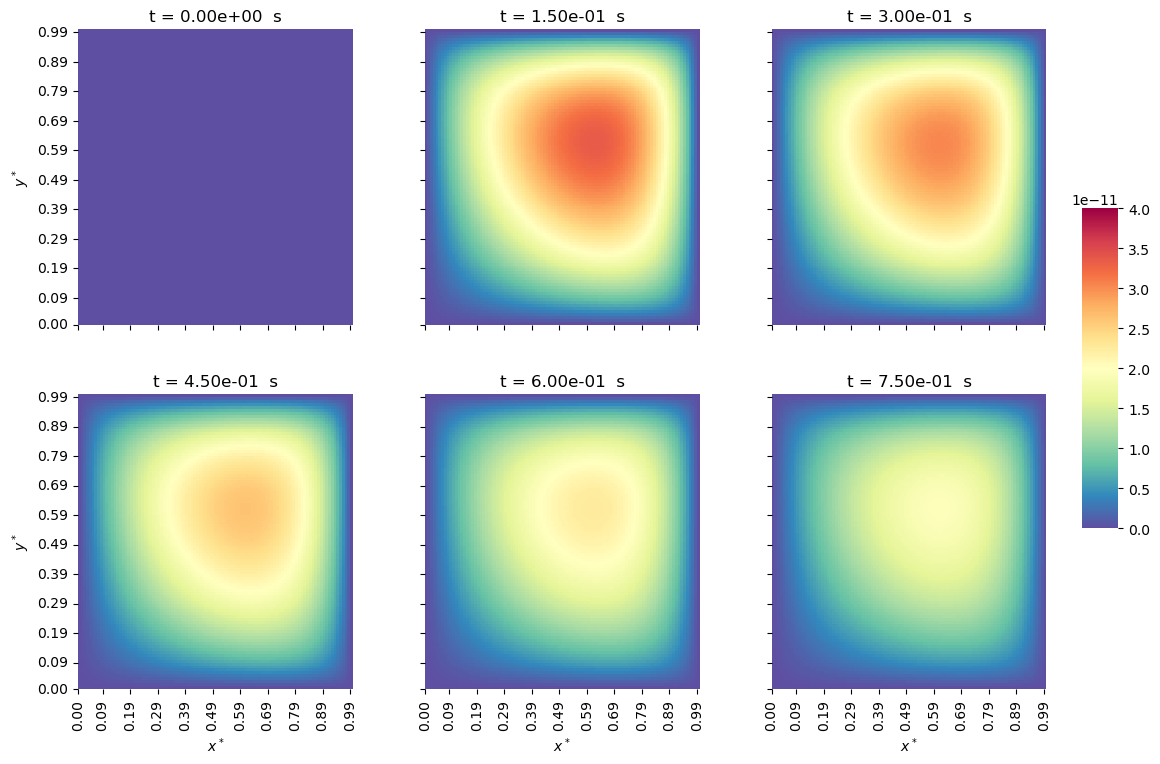

In [70]:
N = 6
start = 0
step = 1_500
setLimits = [0, 4e-11]

nlines = N // 3
fig, axs = plt.subplots(nlines, 3, figsize = (12, 4*nlines), sharex = True, sharey = True)
fig.tight_layout(pad = 5)

num_ticks = 11
# number of points in x and y
nx = len(Xv)
ny = len(Yv)
# the index of the position of yticks
yticks = np.linspace(0, len(Yv) - 1, num_ticks, dtype=int)
xticks = np.linspace(0, len(Xv) - 1, num_ticks, dtype=int)

fmtx = lambda x, pos: '{:.2f}'.format(x*Lx/nx, pos)
fmty = lambda y, pos: '{:.2f}'.format(y*Ly/ny, pos)
    
cbar_ax = fig.add_axes([.91, .3, .03, .4])

fig.tight_layout(pad = 4)
plt.subplots_adjust(right = 0.88)

for i in range(N):
    idxLine = i//3
    idxCol = i % 3

    idx = start + step*i

    T = np.reshape(error[idx], (Nx, Ny))
    
    if len(setLimits) == 0:
        minV = min(T_vec[idx])
        maxV = max(T_vec[idx])
    else:
        minV = setLimits[0]
        maxV = setLimits[1]


    sns.heatmap(
    T,
    ax = axs[idxLine, idxCol],
    cmap = "Spectral_r",
    vmin = minV,
    vmax = maxV,
    cbar_ax= cbar_ax
    )

    axs[idxLine, idxCol].invert_yaxis()
    axs[idxLine, idxCol].set_xticks(xticks)
    axs[idxLine, idxCol].set_yticks(yticks)

    if idxLine == nlines - 1: axs[idxLine, idxCol].set(xlabel = r'$x^*$')
    if idxCol  == 0: axs[idxLine, idxCol].set(ylabel = r'$y^*$')
    axs[idxLine, idxCol].set_title('t = %.2e  s' % ((idx)*dt))
    axs[idxLine, idxCol].xaxis.set_major_formatter(mlp.ticker.FuncFormatter(fmtx))
    axs[idxLine, idxCol].yaxis.set_major_formatter(mlp.ticker.FuncFormatter(fmty))

plt.show()

In [74]:
Error_vec = np.reshape(error, Npoints*Nt)

SRME = np.sqrt(sum(Error_vec**2)/(Nt*Npoints))
MAE = sum(Error_vec)/(Nt*Npoints)
Max  = max(Error_vec)
print('O erro quadrático médio é: %.3e' % (SRME))
print('O erro absoluto médio é: %.3e' % (MAE))
print('O erro máximo é: %.3e' % (Max))

O erro quadrático médio é: 1.325e-11
O erro absoluto médio é: 1.065e-11
O erro máximo é: 3.358e-11


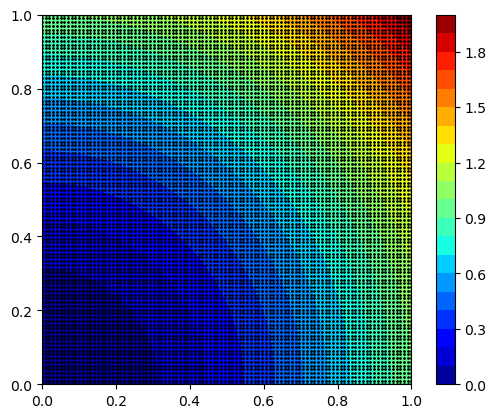

In [271]:
i = 1

# For graphical purposes
Tmin = min(T_vec[i])
Tmax = max(T_vec[i])

# Temperature contourplot
ax = plt.axes()
ax.set_aspect('equal')
ax.triplot(triang,'k.', markersize = 2)
surf = ax.tricontourf(triang,T_vec[i],cmap='jet', levels = np.linspace(Tmin, Tmax, 21))
plt.colorbar(surf)
plt.show()

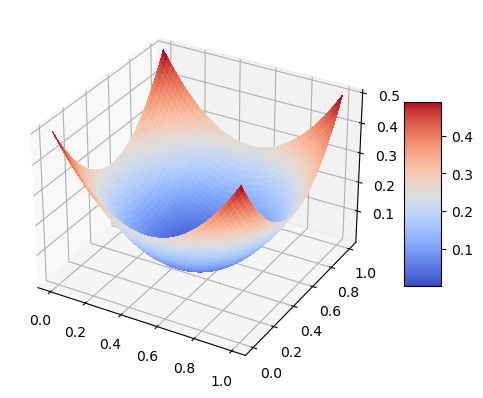

In [100]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
Xz = np.reshape(X, (Nx, Ny))
Yz = np.reshape(Y, (Nx, Ny))
Tz = np.reshape(T_mat, (Nx, Ny))

# Plot the surface.
surf = ax.plot_surface(Xz, Yz, Tz, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

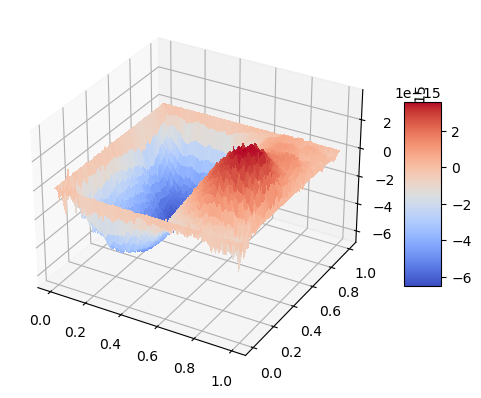

In [101]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

Error = T_vec - (X - 0.5)**2 - (Y - 0.5)**2

# Make data.
Xz = np.reshape(X, (Nx, Ny))
Yz = np.reshape(Y, (Nx, Ny))
Errorz = np.reshape(Error, (Nx, Ny))

# Plot the surface.
surf = ax.plot_surface(Xz, Yz, Errorz, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

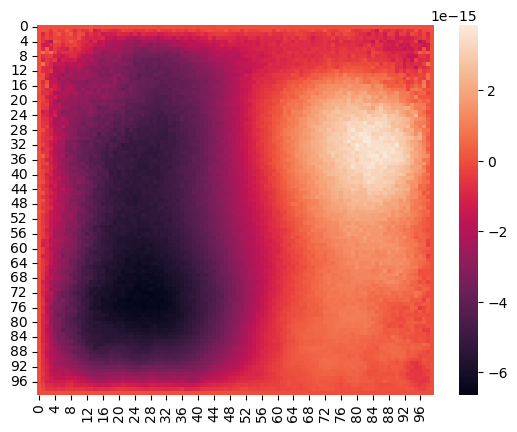

In [102]:
sns.heatmap(np.reshape(Error, (Nx, Ny)))
plt.show()

#### Time test

In [118]:
Nx, Ny = 1000, 1000
Npoints = Nx*Ny

In [119]:
X = np.linspace(0, Lx, Nx, dtype = float)
Y = np.linspace(0, Ly, Ny, dtype = float)

Xv, Yv = np.meshgrid(X, Y)

X = np.reshape(Xv, Npoints)
Y = np.reshape(Yv, Npoints)

In [122]:
K  = np.zeros((Npoints, Npoints), dtype = float) 
M  = np.zeros((Npoints, Npoints), dtype = float)

In [123]:
IEN = [
    [0, Nx + 1, Nx    ],
    [0,      1, Nx + 1]
]

for i in range(Ny - 1):
    
    for j in range(Nx - 2):
        IEN.append([IEN[-2][k] + 1 for k in range(3)])
        IEN.append([IEN[-2][k] + 1 for k in range(3)])

    if i < Ny - 2:
        IEN.append([IEN[0][k] + Nx*(i + 1) for k in range(3)])
        IEN.append([IEN[1][k] + Nx*(i + 1) for k in range(3)])

In [124]:
# Standard way (described in handbook)
t1 = time.time()
for IENelem in IEN:
    x_list = [X[elem] for elem in IENelem]
    y_list = [Y[elem] for elem in IENelem] #find direct slicing of x and y elems

    tri_matrix = [[1, X[IENelem[i]], Y[IENelem[i]]] for i in range(3)]

    tri_area = 0.5*np.linalg.det(tri_matrix)

    a_list = np.array([x_list[(i + 1)%3]*y_list[(i + 2)%3] - x_list[(i + 2)%3]*y_list[(i + 1)%3] for i in range(3)])
    b_list = np.array([y_list[(i + 1)%3] - y_list[(i + 2)%3] for i in range(3)])
    c_list = np.array([x_list[(i + 2)%3] - x_list[(i + 1)%3] for i in range(3)])

    # [a_list, b_list, c_list] = np.linalg.inv(tri_matrix)

    melem = (tri_area/12)*np.array(([2, 1, 1],
                                    [1, 2, 1],
                                    [1, 1, 2]))
    
    kxelem = (alpha/(4*tri_area))*np.array([[b_list[i]*b_list[j] for i in range(3)] for j in range(3)])
    kyelem = (alpha/(4*tri_area))*np.array([[c_list[i]*c_list[j] for i in range(3)] for j in range(3)])

    # kxelem = (alpha*tri_area)*np.array([[b_list[i]*b_list[j] for i in range(3)] for j in range(3)])
    # kyelem = (alpha*tri_area)*np.array([[c_list[i]*c_list[j] for i in range(3)] for j in range(3)])

    kelem = kxelem + kyelem

    for ilocal in range(3):
        iglobal = IENelem[ilocal]

        for jlocal in range(3):
            jglobal = IENelem[jlocal]

            K[iglobal,jglobal] += kelem[ilocal,jlocal]
            M[iglobal,jglobal] += melem[ilocal,jlocal]

t2 = time.time()

print("Time for standard way:  %.3f" % (t2 - t1))

Time for standard way:  71.962


In [125]:
# Standard way (described in handbook)
t1 = time.time()
for IENelem in IEN:
    # x_list = [X[elem] for elem in IENelem]
    # y_list = [Y[elem] for elem in IENelem] #find direct slicing of x and y elems

    tri_matrix = [[1, X[IENelem[i]], Y[IENelem[i]]] for i in range(3)]

    tri_area = 0.5*np.linalg.det(tri_matrix)

    # a_list = np.array([x_list[(i + 1)%3]*y_list[(i + 2)%3] - x_list[(i + 2)%3]*y_list[(i + 1)%3] for i in range(3)])
    # b_list = np.array([y_list[(i + 1)%3] - y_list[(i + 2)%3] for i in range(3)])
    # c_list = np.array([x_list[(i + 2)%3] - x_list[(i + 1)%3] for i in range(3)])

    [a_list, b_list, c_list] = np.linalg.inv(tri_matrix)

    melem = (tri_area/12)*np.array(([2, 1, 1],
                                    [1, 2, 1],
                                    [1, 1, 2]))
    
    # kxelem = (alpha/(4*tri_area))*np.array([[b_list[i]*b_list[j] for i in range(3)] for j in range(3)])
    # kyelem = (alpha/(4*tri_area))*np.array([[c_list[i]*c_list[j] for i in range(3)] for j in range(3)])

    kxelem = (alpha*tri_area)*np.array([[b_list[i]*b_list[j] for i in range(3)] for j in range(3)])
    kyelem = (alpha*tri_area)*np.array([[c_list[i]*c_list[j] for i in range(3)] for j in range(3)])

    kelem = kxelem + kyelem

    for ilocal in range(3):
        iglobal = IENelem[ilocal]

        for jlocal in range(3):
            jglobal = IENelem[jlocal]

            K[iglobal,jglobal] += kelem[ilocal,jlocal]
            M[iglobal,jglobal] += melem[ilocal,jlocal]

t2 = time.time()

print("Time for new way:  %.3f" % (t2 - t1))

Time for new way:  110.659


# Numerical Solution

In [75]:
# Inicialização do primeiro passo de tempo
T_vec = np.zeros((Nt, Npoints))

# for i in cc: T_vec[0][i] = 1
T_vec[0] = np.zeros(Npoints)

In [76]:
A = M/dt + beta*K

for i in cc:
    A[i, :] = 0.0
    A[i, i] = 1.0

Ainv = np.linalg.inv(A)

In [77]:
A2 = M/dt - (1 - beta)*K

In [80]:
for i in tqdm(range(1, Nt)):  
    q_vec = np.full(Npoints, 100) 
    
    b = A2@T_vec[i - 1] + M@q_vec

    for j in cc:
        b[j] = 0

    T_vec[i] = Ainv@b

100%|██████████| 9999/9999 [10:18<00:00, 16.17it/s]


In [ ]:
expected_T = np.array([[Tcc(X[i], Y[i], T[j]) for i in range(Npoints)] for j in range(Nt)])

In [ ]:
error = abs(T_vec - expected_T)

In [ ]:
error_MSE = [np.sqrt(sum(elem**2)/Npoints) for elem in error]

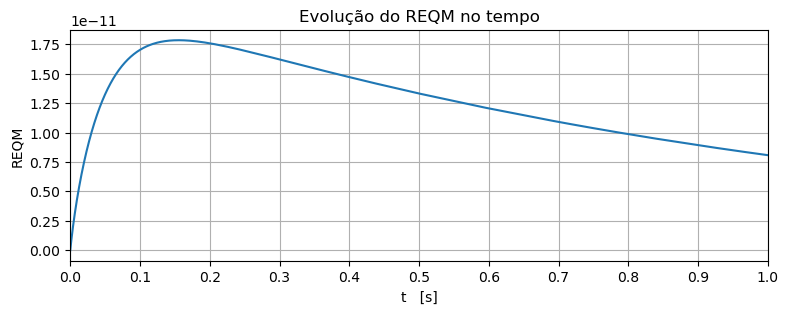

In [ ]:
fig, axs = plt.subplots(1, 1, figsize = (9, 3))
plt.plot(T, error_MSE)
plt.grid()
plt.xlabel('t   [s]')
plt.ylabel('REQM')
plt.title('Evolução do REQM no tempo')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.xlim(0, 1)
plt.show()